In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import cv2
import os
from pathlib import Path
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')


In [ ]:
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/chest_xray/train'
VAL_DIR = '/content/drive/MyDrive/chest_xray/val'
TEST_DIR = '/content/drive/MyDrive/chest_xray/test'

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 50

In [ ]:
def validate_directory(dir_path, dir_name):
    """Check if directory exists and contains required subdirectories"""
    if not os.path.exists(dir_path):
        print(f"❌ {dir_name} directory NOT FOUND: {dir_path}")
        return False

    normal_path = os.path.join(dir_path, 'NORMAL')
    pneumonia_path = os.path.join(dir_path, 'PNEUMONIA')

    normal_exists = os.path.exists(normal_path)
    pneumonia_exists = os.path.exists(pneumonia_path)

    if normal_exists and pneumonia_exists:
        normal_count = len([f for f in os.listdir(normal_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        pneumonia_count = len([f for f in os.listdir(pneumonia_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"✓ {dir_name:12} found: {dir_path}")
        print(f"  - NORMAL: {normal_count} images")
        print(f"  - PNEUMONIA: {pneumonia_count} images")
        return True
    else:
        print(f"❌ {dir_name} missing subdirectories:")
        if not normal_exists:
            print(f"  - NORMAL folder not found: {normal_path}")
        if not pneumonia_exists:
            print(f"  - PNEUMONIA folder not found: {pneumonia_path}")
        return False

# Validate all directories
train_valid = validate_directory(TRAIN_DIR, "Training")
val_valid = validate_directory(VAL_DIR, "Validation")
test_valid = validate_directory(TEST_DIR, "Test")

if not (train_valid and val_valid and test_valid):
    print("\n" + "="*70)
    print("ERROR: DATASET NOT FOUND OR INCOMPLETE!")
    print("="*70)
    print("\nTo download the dataset:")
    print("1. Visit: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")
    print("2. Download and extract the 'chest_xray.zip' file")
    print("3. Update the paths at the top of this script (lines 33-35)")
    print("4. Make sure the directory structure matches the expected format")
    print("\nAlternatively, if using Kaggle or Colab:")
    print("- Kaggle: Uncomment lines 38-40")
    print("- Colab: Uncomment lines 43-45 and mount your Google Drive")
    print("="*70)
    raise FileNotFoundError("Dataset not found. Please download and configure the dataset paths.")

print("\n✓ All dataset paths validated successfully!")

✓ Training     found: /content/drive/MyDrive/chest_xray/train
  - NORMAL: 1341 images
  - PNEUMONIA: 3875 images
✓ Validation   found: /content/drive/MyDrive/chest_xray/val
  - NORMAL: 8 images
  - PNEUMONIA: 8 images
✓ Test         found: /content/drive/MyDrive/chest_xray/test
  - NORMAL: 234 images
  - PNEUMONIA: 390 images

✓ All dataset paths validated successfully!


In [ ]:
def load_and_preprocess_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Load image, convert to grayscale, resize, and normalize"""
    try:
        # Read image
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")

        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize
        img_resized = cv2.resize(img_gray, target_size)

        # Normalize to [0, 1]
        img_normalized = img_resized / 255.0

        return img_normalized
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

In [ ]:
def load_dataset(data_dir):
    """Load all images and labels from directory"""
    images = []
    labels = []

    # Classes: NORMAL (0) and PNEUMONIA (1)
    classes = ['NORMAL', 'PNEUMONIA']

    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: {class_path} does not exist!")
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"Loading {len(image_files)} images from {class_name}...")

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            img = load_and_preprocess_image(img_path)
            if img is not None:
                images.append(img)
                labels.append(class_idx)

    return np.array(images), np.array(labels)

In [ ]:
print("\nLoading training data...")
X_train, y_train = load_dataset(TRAIN_DIR)


Loading training data...
Loading 1341 images from NORMAL...
Loading 3875 images from PNEUMONIA...


In [ ]:
print("\nLoading test data...")
X_test, y_test = load_dataset(TEST_DIR)



Loading test data...
Loading 234 images from NORMAL...
Loading 390 images from PNEUMONIA...


In [ ]:
print("\nLoading validation data...")
X_val, y_val = load_dataset(VAL_DIR)


Loading validation data...
Loading 8 images from NORMAL...
Loading 8 images from PNEUMONIA...


In [ ]:
if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
    raise ValueError("No images were loaded! Please check your dataset paths and structure.")


In [ ]:
X_train = X_train.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
X_val = X_val.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
X_test = X_test.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

In [ ]:
print(f"\n" + "="*70)
print("DATASET SUMMARY")
print("="*70)
print(f"Training:   {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test:       {X_test.shape}, Labels: {y_test.shape}")


DATASET SUMMARY
Training:   (5216, 224, 224, 1), Labels: (5216,)
Validation: (16, 224, 224, 1), Labels: (16,)
Test:       (624, 224, 224, 1), Labels: (624,)


In [ ]:
print(f"\nClass Distribution:")
print(f"Training   - Normal: {np.sum(y_train == 0):4d}, Pneumonia: {np.sum(y_train == 1):4d}")
print(f"Validation - Normal: {np.sum(y_val == 0):4d}, Pneumonia: {np.sum(y_val == 1):4d}")
print(f"Test       - Normal: {np.sum(y_test == 0):4d}, Pneumonia: {np.sum(y_test == 1):4d}")



Class Distribution:
Training   - Normal: 1341, Pneumonia: 3875
Validation - Normal:    8, Pneumonia:    8
Test       - Normal:  234, Pneumonia:  390



Generating sample X-ray visualization...


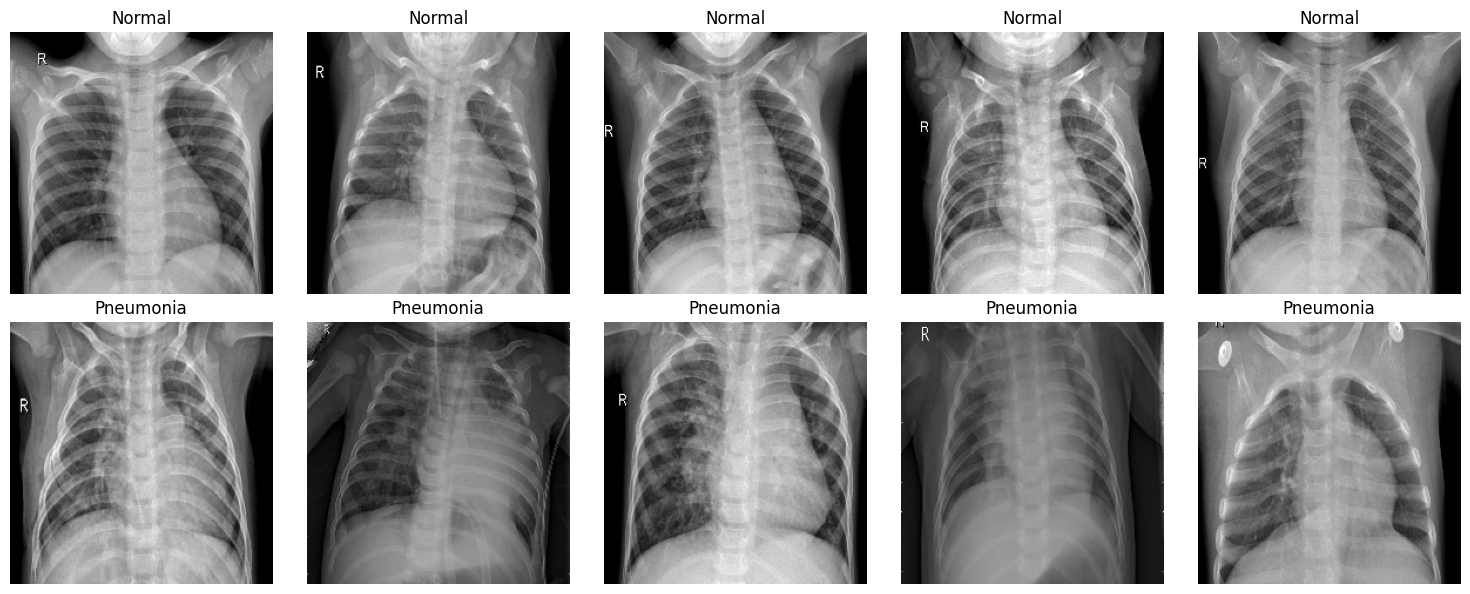

✓ Saved: sample_xrays.png


In [ ]:
print("\nGenerating sample X-ray visualization...")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Normal images
    axes[0, i].imshow(X_train[y_train == 0][i].squeeze(), cmap='gray')
    axes[0, i].set_title('Normal')
    axes[0, i].axis('off')

    # Pneumonia images
    axes[1, i].imshow(X_train[y_train == 1][i].squeeze(), cmap='gray')
    axes[1, i].set_title('Pneumonia')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('sample_xrays.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: sample_xrays.png")


In [ ]:
sample_normal_idx = np.where(y_train == 0)[0][0]
sample_pneumonia_idx = np.where(y_train == 1)[0][0]



Generating grayscale processing visualization...


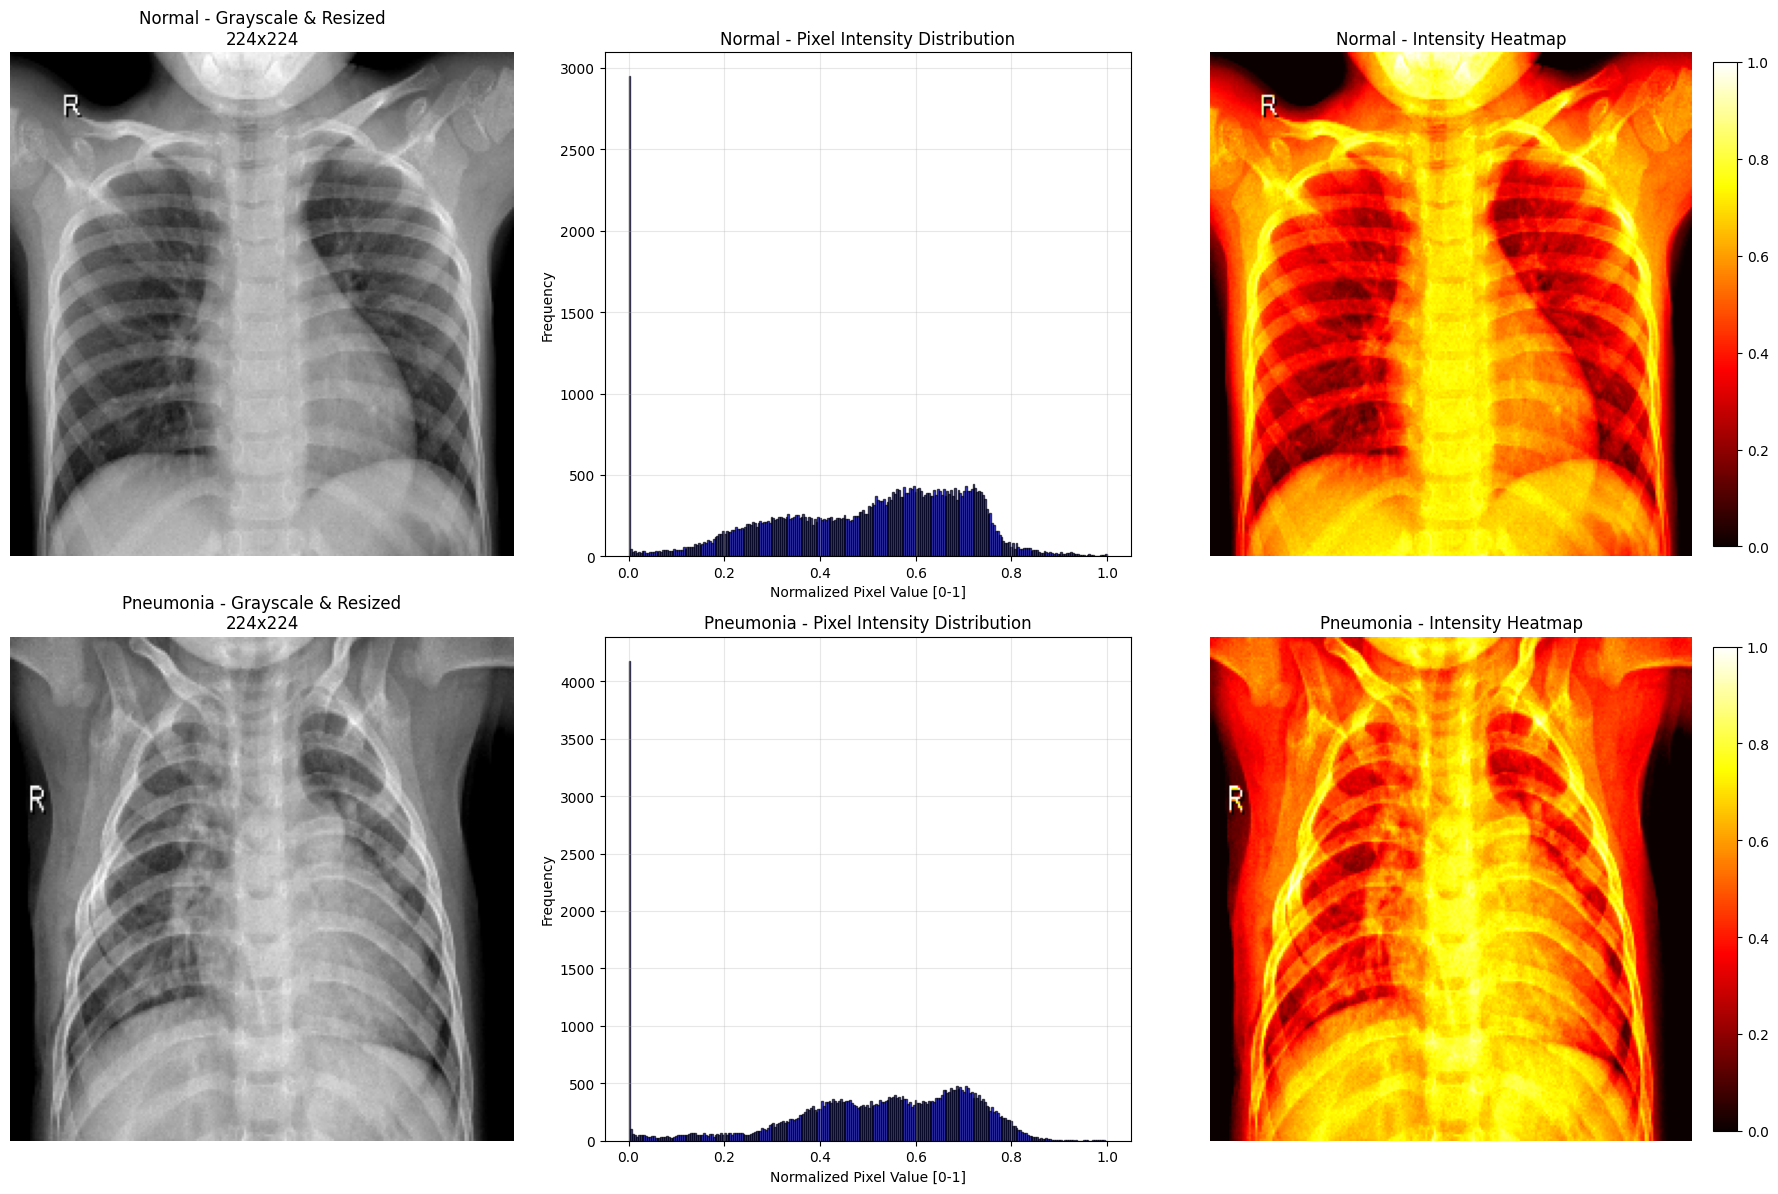

✓ Saved: grayscale_processing_visualization.png


In [ ]:
print("\nGenerating grayscale processing visualization...")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for row, (idx, label) in enumerate([(sample_normal_idx, 'Normal'),
                                      (sample_pneumonia_idx, 'Pneumonia')]):
    # Original processed image
    img_processed = X_train[idx].squeeze()

    # Axes 0: Processed grayscale image
    axes[row, 0].imshow(img_processed, cmap='gray')
    axes[row, 0].set_title(f'{label} - Grayscale & Resized\n{IMG_HEIGHT}x{IMG_WIDTH}', fontsize=12)
    axes[row, 0].axis('off')

    # Axes 1: Pixel intensity histogram
    axes[row, 1].hist(img_processed.ravel(), bins=256, range=(0, 1),
                      color='blue', alpha=0.7, edgecolor='black')
    axes[row, 1].set_title(f'{label} - Pixel Intensity Distribution', fontsize=12)
    axes[row, 1].set_xlabel('Normalized Pixel Value [0-1]')
    axes[row, 1].set_ylabel('Frequency')
    axes[row, 1].grid(True, alpha=0.3)

    # Axes 2: Intensity heatmap
    im = axes[row, 2].imshow(img_processed, cmap='hot', aspect='auto')
    axes[row, 2].set_title(f'{label} - Intensity Heatmap', fontsize=12)
    axes[row, 2].axis('off')
    plt.colorbar(im, ax=axes[row, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('grayscale_processing_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: grayscale_processing_visualization.png")

In [ ]:
sample_img = X_train[sample_normal_idx]
print(f"Image shape after preprocessing: {sample_img.shape}")
print(f"  - Height: {sample_img.shape[0]} pixels")
print(f"  - Width: {sample_img.shape[1]} pixels")
print(f"  - Channels: {sample_img.shape[2]} (grayscale)")
print(f"\nTotal pixels per image: {sample_img.shape[0] * sample_img.shape[1]}")
print(f"Total values (vectorized): {sample_img.size}")


Image shape after preprocessing: (224, 224, 1)
  - Height: 224 pixels
  - Width: 224 pixels
  - Channels: 1 (grayscale)

Total pixels per image: 50176
Total values (vectorized): 50176


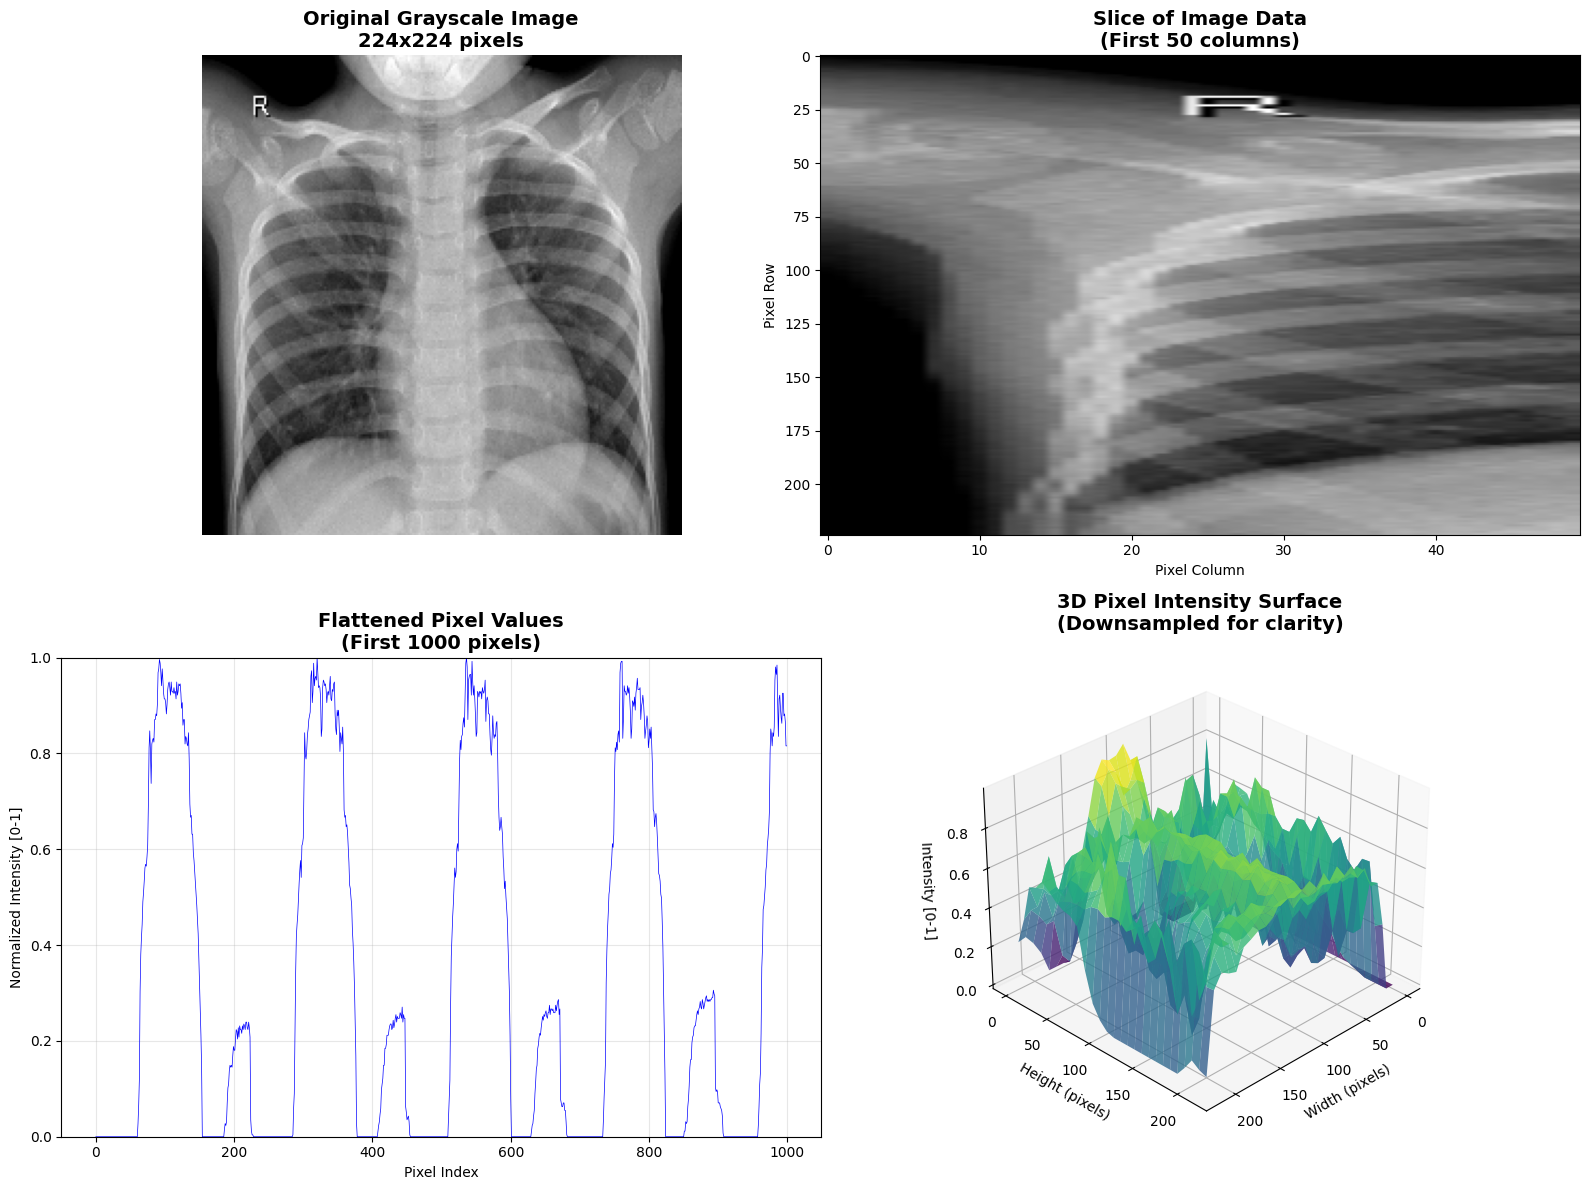

✓ Saved: vectorization_visualization.png


In [ ]:
# Visualize vectorization concept
fig = plt.figure(figsize=(16, 12))

# Sample image
sample_viz = X_train[sample_normal_idx].squeeze()

# Create subplots
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4, projection='3d')

# Top-left: Original image
ax1.imshow(sample_viz, cmap='gray')
ax1.set_title('Original Grayscale Image\n224x224 pixels', fontsize=14, weight='bold')
ax1.axis('off')

# Top-right: Show a slice of the vectorized data
vector_slice = sample_viz[:, :50]  # First 50 columns
ax2.imshow(vector_slice, cmap='gray', aspect='auto')
ax2.set_title('Slice of Image Data\n(First 50 columns)', fontsize=14, weight='bold')
ax2.set_xlabel('Pixel Column')
ax2.set_ylabel('Pixel Row')

# Bottom-left: Flattened vector visualization (sample)
flattened = sample_viz.flatten()[:1000]  # First 1000 values
ax3.plot(flattened, linewidth=0.5, color='blue')
ax3.set_title('Flattened Pixel Values\n(First 1000 pixels)', fontsize=14, weight='bold')
ax3.set_xlabel('Pixel Index')
ax3.set_ylabel('Normalized Intensity [0-1]')
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0, 1])

# Bottom-right: 3D representation of pixel grid
# Sample every 8th pixel for visualization (to avoid overcrowding)
step = 8
x_coords, y_coords = np.meshgrid(
    np.arange(0, IMG_HEIGHT, step),
    np.arange(0, IMG_WIDTH, step)
)
z_coords = sample_viz[::step, ::step]

ax4.plot_surface(x_coords, y_coords, z_coords, cmap='viridis',
                 alpha=0.8, edgecolor='none')
ax4.set_title('3D Pixel Intensity Surface\n(Downsampled for clarity)',
              fontsize=14, weight='bold', pad=20)
ax4.set_xlabel('Width (pixels)', fontsize=10)
ax4.set_ylabel('Height (pixels)', fontsize=10)
ax4.set_zlabel('Intensity [0-1]', fontsize=10)
ax4.view_init(elev=30, azim=45)

plt.tight_layout()
plt.savefig('vectorization_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: vectorization_visualization.png")


Generating batch processing visualization...


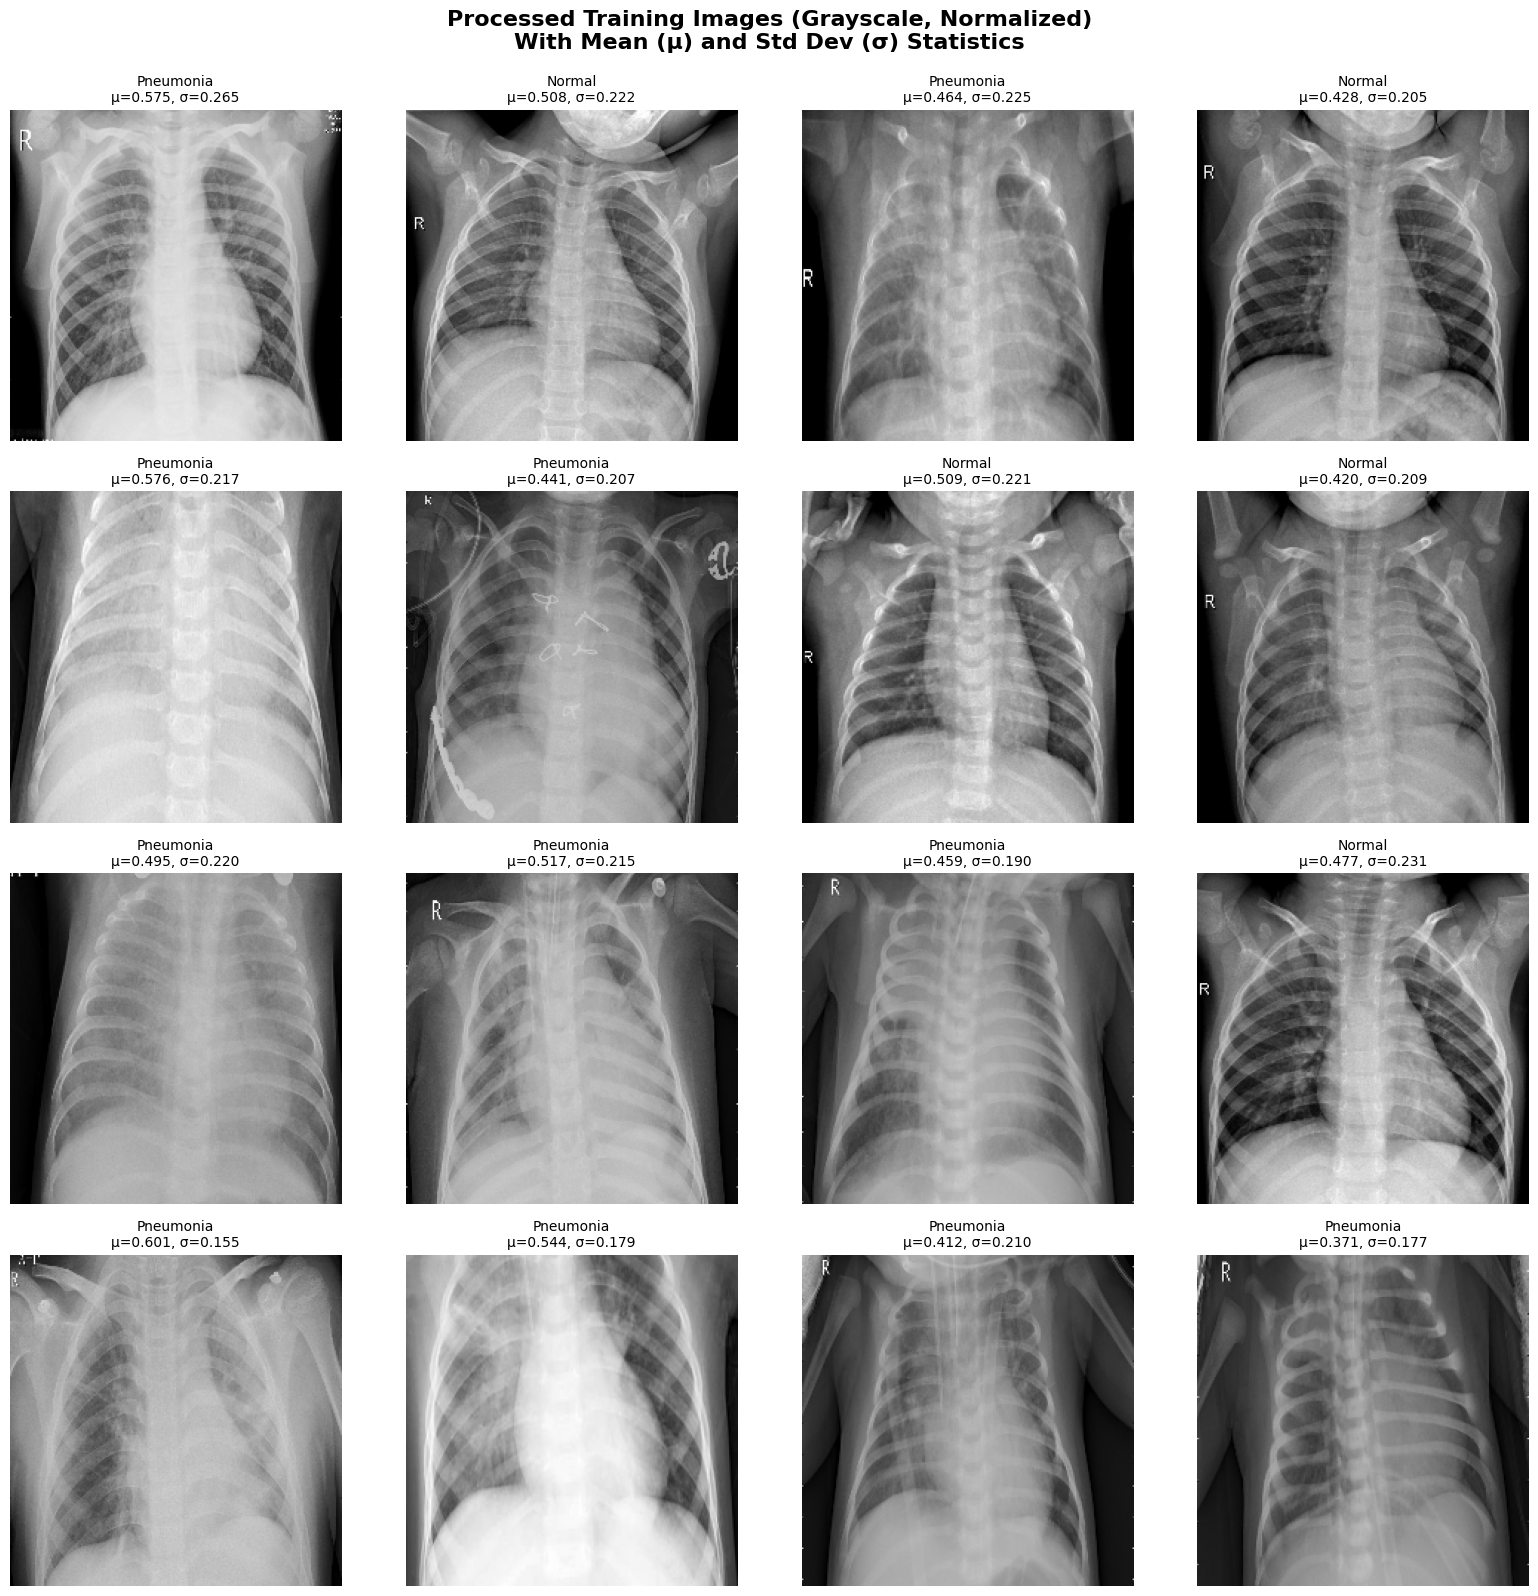

✓ Saved: batch_processed_images.png


In [ ]:
print("\nGenerating batch processing visualization...")
n_samples = 16
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.ravel()

for i in range(n_samples):
    idx = np.random.randint(0, len(X_train))
    img = X_train[idx].squeeze()
    label = 'Pneumonia' if y_train[idx] == 1 else 'Normal'

    # Calculate image statistics
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'{label}\nμ={mean_intensity:.3f}, σ={std_intensity:.3f}',
                      fontsize=10)
    axes[i].axis('off')

plt.suptitle('Processed Training Images (Grayscale, Normalized)\nWith Mean (μ) and Std Dev (σ) Statistics',
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.savefig('batch_processed_images.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: batch_processed_images.png")

In [ ]:
normal_images = X_train[y_train == 0]
pneumonia_images = X_train[y_train == 1]

stats_data = {
    'Class': ['Normal', 'Pneumonia', 'Overall'],
    'Mean Intensity': [
        np.mean(normal_images),
        np.mean(pneumonia_images),
        np.mean(X_train)
    ],
    'Std Dev': [
        np.std(normal_images),
        np.std(pneumonia_images),
        np.std(X_train)
    ],
    'Min Value': [
        np.min(normal_images),
        np.min(pneumonia_images),
        np.min(X_train)
    ],
    'Max Value': [
        np.max(normal_images),
        np.max(pneumonia_images),
        np.max(X_train)
    ]
}

stats_df = pd.DataFrame(stats_data)
print(stats_df.to_string(index=False))

    Class  Mean Intensity  Std Dev  Min Value  Max Value
   Normal        0.479486 0.246874        0.0        1.0
Pneumonia        0.482756 0.233941        0.0        1.0
  Overall        0.481915 0.237338        0.0        1.0


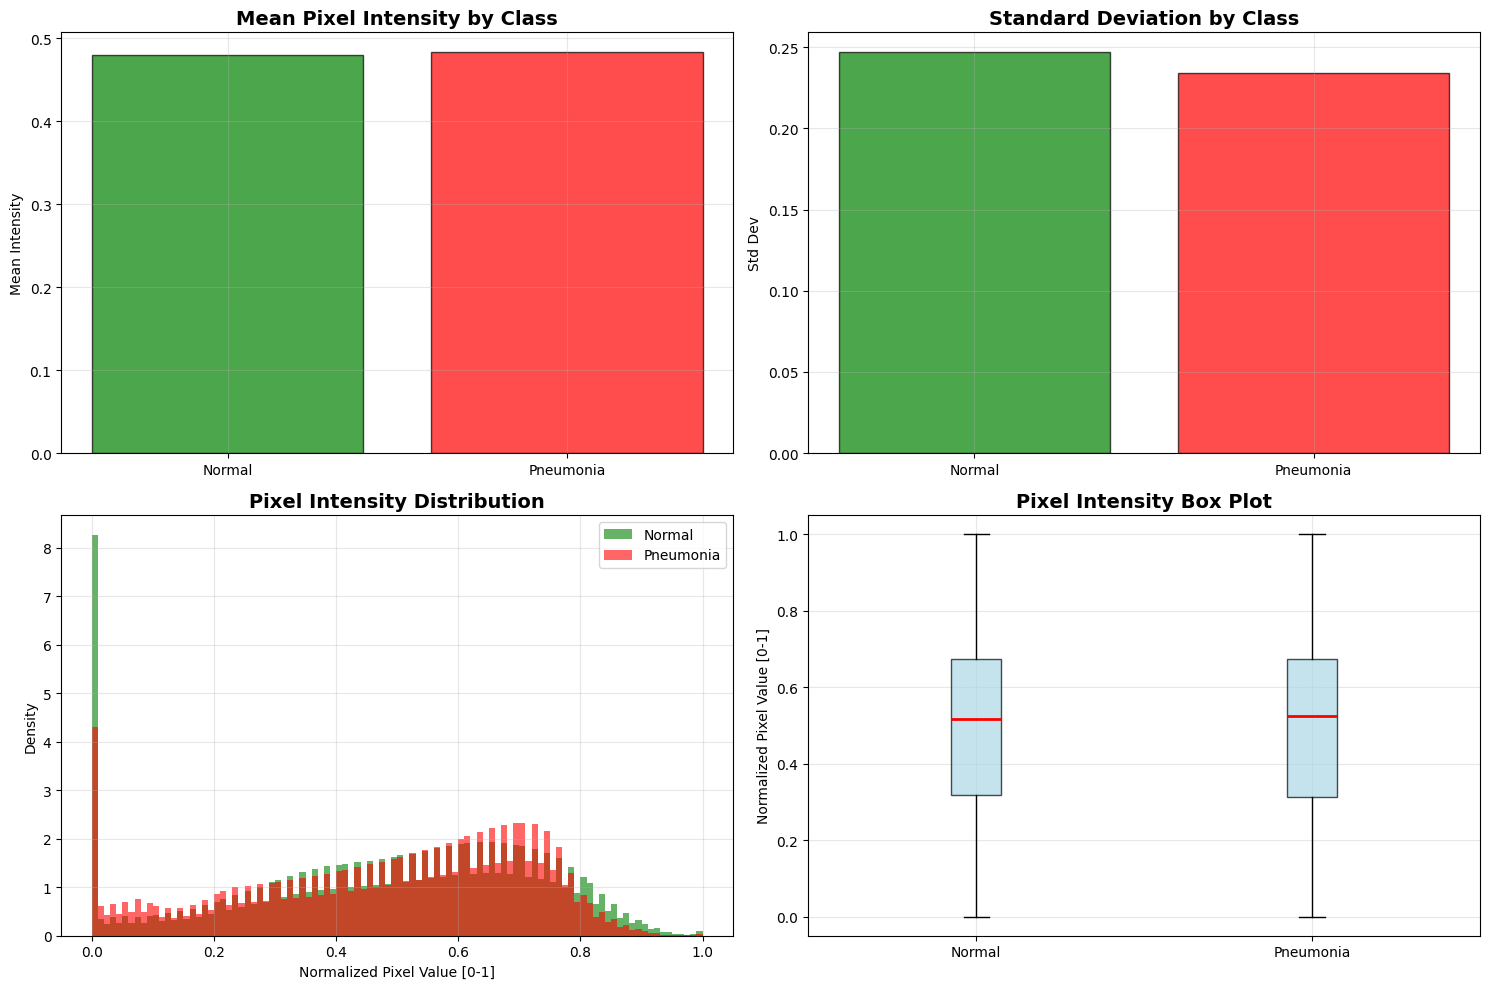

✓ Saved: statistical_analysis.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].bar(['Normal', 'Pneumonia'],
               [np.mean(normal_images), np.mean(pneumonia_images)],
               color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Mean Pixel Intensity by Class', fontsize=14, weight='bold')
axes[0, 0].set_ylabel('Mean Intensity')
axes[0, 0].grid(True, alpha=0.3)

# Standard deviation comparison
axes[0, 1].bar(['Normal', 'Pneumonia'],
               [np.std(normal_images), np.std(pneumonia_images)],
               color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Standard Deviation by Class', fontsize=14, weight='bold')
axes[0, 1].set_ylabel('Std Dev')
axes[0, 1].grid(True, alpha=0.3)

# Distribution comparison
axes[1, 0].hist(normal_images.ravel(), bins=100, alpha=0.6,
                label='Normal', color='green', density=True)
axes[1, 0].hist(pneumonia_images.ravel(), bins=100, alpha=0.6,
                label='Pneumonia', color='red', density=True)
axes[1, 0].set_title('Pixel Intensity Distribution', fontsize=14, weight='bold')
axes[1, 0].set_xlabel('Normalized Pixel Value [0-1]')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Box plot comparison
axes[1, 1].boxplot([normal_images.ravel()[::100], pneumonia_images.ravel()[::100]],
                   labels=['Normal', 'Pneumonia'],
                   patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[1, 1].set_title('Pixel Intensity Box Plot', fontsize=14, weight='bold')
axes[1, 1].set_ylabel('Normalized Pixel Value [0-1]')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('statistical_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: statistical_analysis.png")

In [ ]:
print("\n" + "="*70)
print("DATA SHAPE SUMMARY AFTER PROCESSING")
print("="*70)
print(f"\nTraining Data:")
print(f"  Shape: {X_train.shape}")
print(f"  - Number of samples: {X_train.shape[0]}")
print(f"  - Image height: {X_train.shape[1]} pixels")
print(f"  - Image width: {X_train.shape[2]} pixels")
print(f"  - Channels: {X_train.shape[3]} (grayscale)")
print(f"  - Total parameters per image: {np.prod(X_train.shape[1:])}")
print(f"  - Memory size: {X_train.nbytes / (1024**2):.2f} MB")

print(f"\nValidation Data:")
print(f"  Shape: {X_val.shape}")
print(f"  Memory size: {X_val.nbytes / (1024**2):.2f} MB")

print(f"\nTest Data:")
print(f"  Shape: {X_test.shape}")
print(f"  Memory size: {X_test.nbytes / (1024**2):.2f} MB")

print(f"\nTotal Dataset Memory: {(X_train.nbytes + X_val.nbytes + X_test.nbytes) / (1024**2):.2f} MB")

print("\n" + "="*70)
print("DATA PROCESSING VISUALIZATION COMPLETE")
print("="*70)



DATA SHAPE SUMMARY AFTER PROCESSING

Training Data:
  Shape: (5216, 224, 224, 1)
  - Number of samples: 5216
  - Image height: 224 pixels
  - Image width: 224 pixels
  - Channels: 1 (grayscale)
  - Total parameters per image: 50176
  - Memory size: 1996.75 MB

Validation Data:
  Shape: (16, 224, 224, 1)
  Memory size: 6.12 MB

Test Data:
  Shape: (624, 224, 224, 1)
  Memory size: 238.88 MB

Total Dataset Memory: 2241.75 MB

DATA PROCESSING VISUALIZATION COMPLETE


In [ ]:
def build_dcnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)):
    """Build a Deep Convolutional Neural Network"""

    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output Layer (sigmoid for binary classification)
        layers.Dense(1, activation='sigmoid')
    ])

    return model


In [ ]:
# Build the model
model = build_dcnn_model()

In [ ]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()]
)

In [ ]:
# Display model architecture
print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,000,801 (103.00 MB)

 Trainable params: 26,997,345 (102.99 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [ ]:
# Plot model architecture
print("\nGenerating model architecture diagram...")
keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
print("✓ Saved: model_architecture.png")


Generating model architecture diagram...
✓ Saved: model_architecture.png


In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Create augmented training data generator
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [ ]:

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_pneumonia_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]


In [ ]:
# Train the model
print("\nStarting training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training complete!")


Starting training...
Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7879 - auc: 0.8775 - loss: 0.5485 - precision: 0.9246 - recall: 0.7733
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 211ms/step - accuracy: 0.7883 - auc: 0.8778 - loss: 0.5477 - precision: 0.9247 - recall: 0.7738 - val_accuracy: 0.5000 - val_auc: 0.8203 - val_loss: 2.1580 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9070 - auc: 0.9491 - loss: 0.2722 - precision: 0.9447 - recall: 0.9286
Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - accuracy: 0.9070 - auc: 0.9491 - loss: 0.2721 - precision: 0.9447 - recall: 0.9286 - val_accuracy: 0.5000 - val_auc: 0.3828 - val_loss: 1.7569 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9122 - auc: 0.9575 - loss: 0.2374 - precision: 0.9391 - recall: 0.9430
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - accuracy: 0.9122 - auc: 0.9576 - loss: 0.2373 - precision:

163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 205ms/step - accuracy: 0.9221 - auc: 0.9673 - loss: 0.2066 - precision: 0.9490 - recall: 0.9457 - val_accuracy: 0.7500 - val_auc: 0.6719 - val_loss: 1.2733 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9275 - auc: 0.9693 - loss: 0.1961 - precision: 0.9505 - recall: 0.9520
Epoch 5: val_accuracy did not improve from 0.75000
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 179ms/step - accuracy: 0.9276 - auc: 0.9693 - loss: 0.1960 - precision: 0.9505 - recall: 0.9521 - val_accuracy: 0.5625 - val_auc: 0.4531 - val_loss: 4.5036 - val_precision: 1.0000 - val_recall: 0.1250 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9293 - auc: 0.9727 - loss: 0.1883 - precision: 0.9530 - recall: 0.9514
Epoch 6: val_accuracy did not improve from 0.75000
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - accuracy: 0.9293 - auc: 0.9727 - loss: 0.1882 - precision:

163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 186ms/step - accuracy: 0.9730 - auc: 0.9952 - loss: 0.0747 - precision: 0.9821 - recall: 0.9817 - val_accuracy: 0.8750 - val_auc: 0.9531 - val_loss: 0.3377 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 2.5000e-04
Epoch 26/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9680 - auc: 0.9932 - loss: 0.0842 - precision: 0.9767 - recall: 0.9804
Epoch 26: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 179ms/step - accuracy: 0.9680 - auc: 0.9932 - loss: 0.0841 - precision: 0.9767 - recall: 0.9804 - val_accuracy: 0.5625 - val_auc: 0.6875 - val_loss: 2.9134 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 27/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9677 - auc: 0.9929 - loss: 0.0866 - precision: 0.9753 - recall: 0.9811
Epoch 27: val_accuracy improved from 0.87500 to 0.93750, saving model to best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 224ms/step - accuracy: 0.9677 - auc: 0.9929 - loss: 0.0866 - precision: 0.9753 - recall: 0.9811 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.1923 - val_precision: 1.0000 - val_recall: 0.8750 - learning_rate: 2.5000e-04
Epoch 28/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9696 - auc: 0.9921 - loss: 0.0965 - precision: 0.9826 - recall: 0.9763
Epoch 28: val_accuracy did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 178ms/step - accuracy: 0.9697 - auc: 0.9921 - loss: 0.0964 - precision: 0.9826 - recall: 0.9763 - val_accuracy: 0.5000 - val_auc: 0.8438 - val_loss: 1.9854 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 29/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9729 - auc: 0.9965 - loss: 0.0670 - precision: 0.9831 - recall: 0.9804
Epoch 29: val_accuracy did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - accuracy: 0.9729 - auc: 0.9965 - loss: 0.0670 


Generating training history plots...


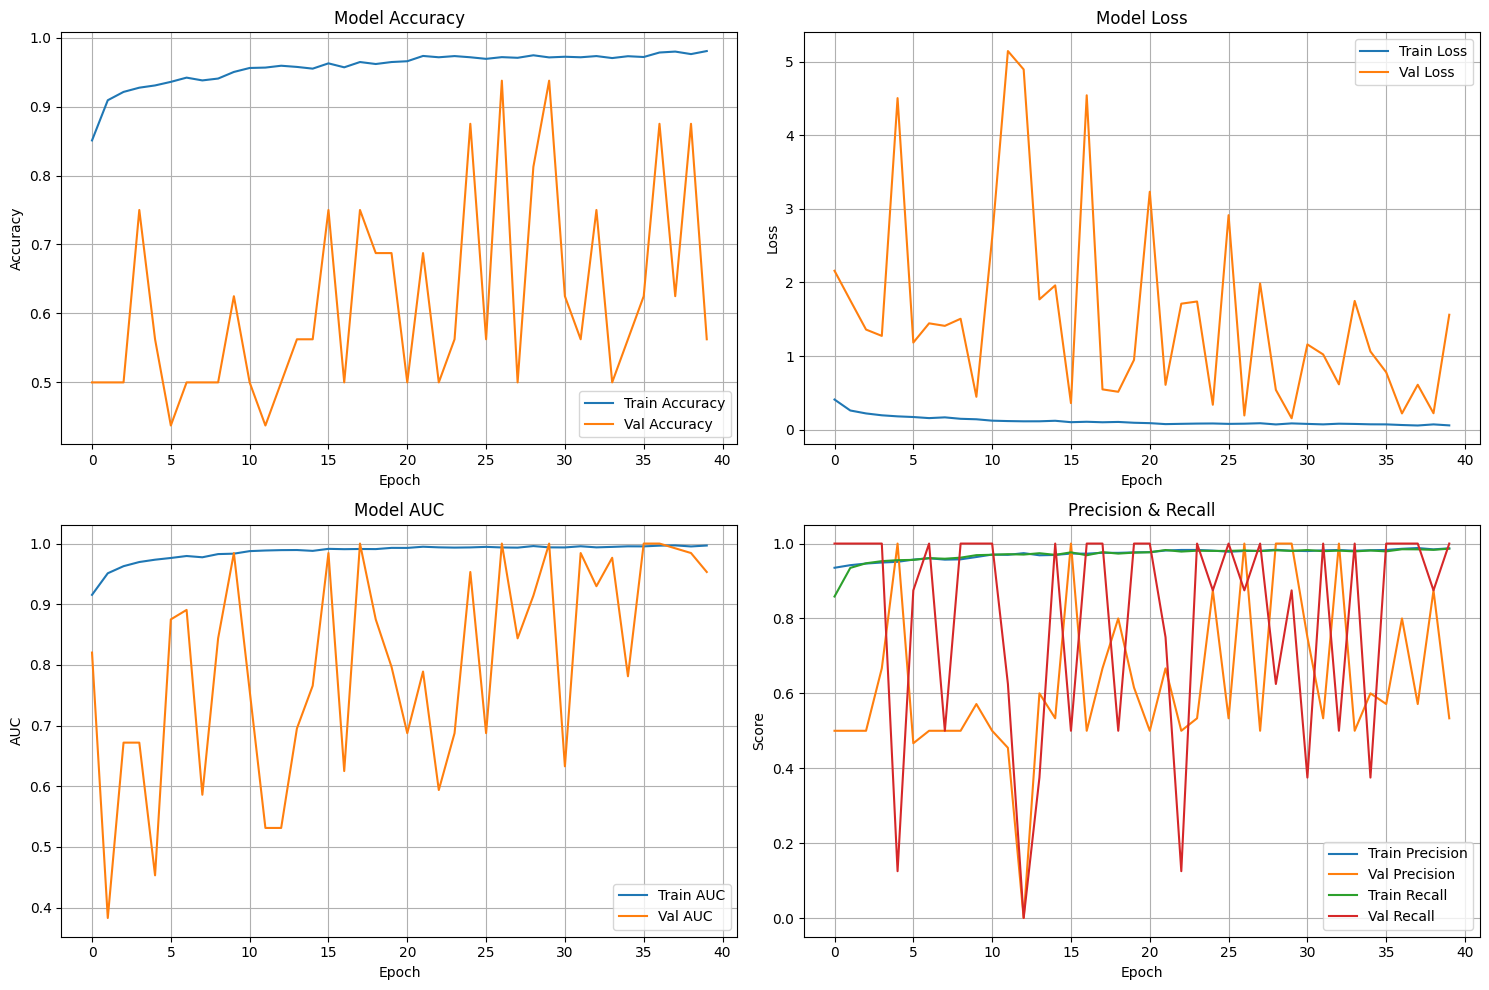

✓ Saved: training_history.png


In [ ]:
# Plot training history
print("\nGenerating training history plots...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss')
axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# AUC
axes[1, 0].plot(history.history['auc'], label='Train AUC')
axes[1, 0].plot(history.history['val_auc'], label='Val AUC')
axes[1, 0].set_title('Model AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Precision & Recall
axes[1, 1].plot(history.history['precision'], label='Train Precision')
axes[1, 1].plot(history.history['val_precision'], label='Val Precision')
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_title('Precision & Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: training_history.png")


In [ ]:
# Predict on test set
print("\nGenerating predictions on test set...")
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


Generating predictions on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step


In [ ]:
# Calculate risk scores (probability of pneumonia)
risk_scores = y_pred_prob.flatten()

In [ ]:
# Evaluation metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test, verbose=0)

print(f"\nTest Metrics:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  AUC: {test_auc:.4f}")



Test Metrics:
  Loss: 0.2481
  Accuracy: 0.9151
  Precision: 0.9332
  Recall: 0.9308
  AUC: 0.9621


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia']))



Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.89      0.89       234
   Pneumonia       0.93      0.93      0.93       390

    accuracy                           0.92       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624




Generating confusion matrix...


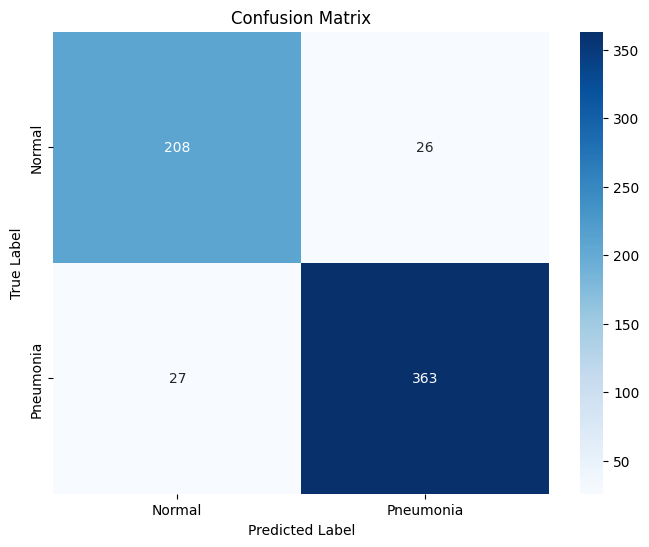

✓ Saved: confusion_matrix.png


In [ ]:
# Confusion Matrix
print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: confusion_matrix.png")



Generating ROC curve...


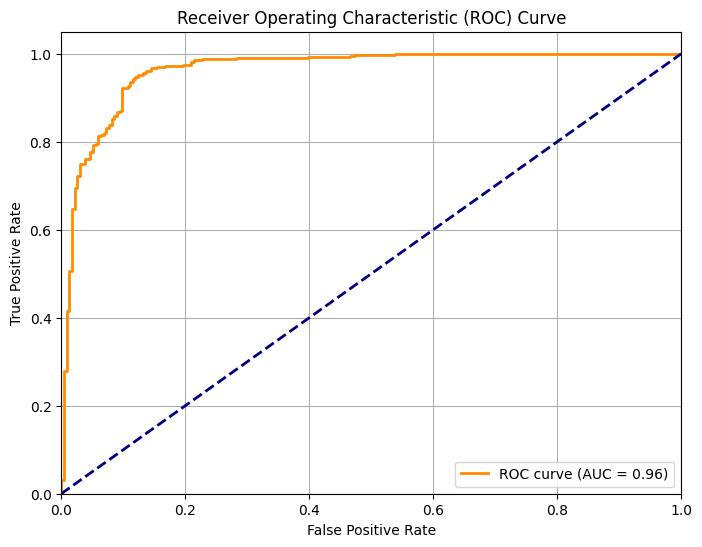

✓ Saved: roc_curve.png


In [ ]:
# ROC Curve
print("\nGenerating ROC curve...")
fpr, tpr, thresholds = roc_curve(y_test, risk_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: roc_curve.png")


Generating risk score distribution plots...


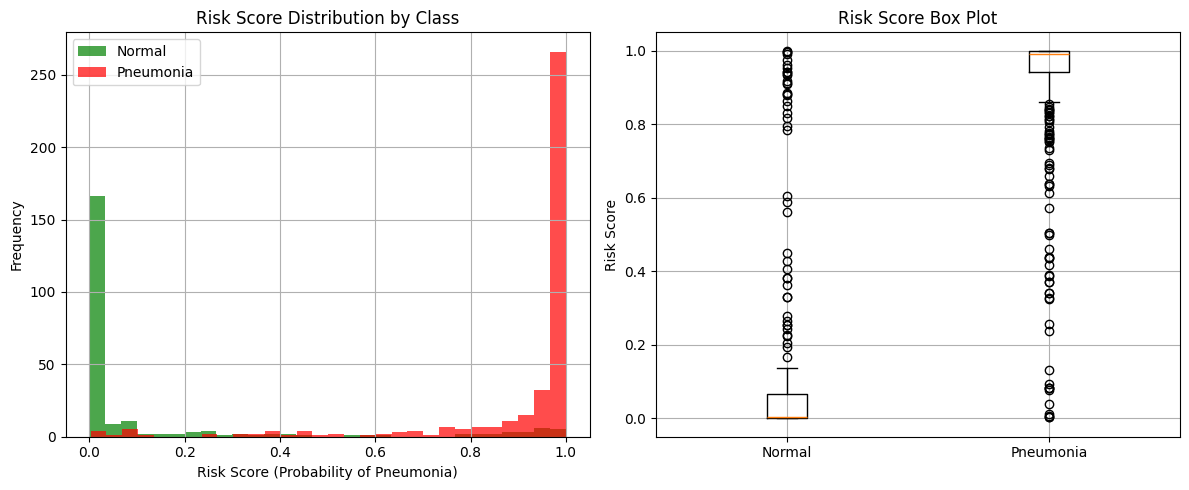

✓ Saved: risk_score_distribution.png


In [ ]:
# Risk Score Distribution
print("\nGenerating risk score distribution plots...")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(risk_scores[y_test == 0], bins=30, alpha=0.7, label='Normal', color='green')
plt.hist(risk_scores[y_test == 1], bins=30, alpha=0.7, label='Pneumonia', color='red')
plt.xlabel('Risk Score (Probability of Pneumonia)')
plt.ylabel('Frequency')
plt.title('Risk Score Distribution by Class')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot([risk_scores[y_test == 0], risk_scores[y_test == 1]], labels=['Normal', 'Pneumonia'])
plt.ylabel('Risk Score')
plt.title('Risk Score Box Plot')
plt.grid(True)

plt.tight_layout()
plt.savefig('risk_score_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: risk_score_distribution.png")

In [ ]:

# Function to interpret risk score
def interpret_risk(risk_score):
    """Interpret risk score and return risk level with color"""
    if risk_score < 0.3:
        return "Low Risk", "green"
    elif risk_score < 0.7:
        return "Medium Risk", "orange"
    else:
        return "High Risk", "red"

In [ ]:

# Create detailed risk score analysis
print("\nRisk Score Categories:")
print("-" * 70)
low_risk = np.sum(risk_scores < 0.3)
medium_risk = np.sum((risk_scores >= 0.3) & (risk_scores < 0.7))
high_risk = np.sum(risk_scores >= 0.7)

print(f"Low Risk (< 30%):      {low_risk:4d} patients ({low_risk/len(risk_scores)*100:.1f}%)")
print(f"Medium Risk (30-70%):  {medium_risk:4d} patients ({medium_risk/len(risk_scores)*100:.1f}%)")
print(f"High Risk (> 70%):     {high_risk:4d} patients ({high_risk/len(risk_scores)*100:.1f}%)")


Risk Score Categories:
----------------------------------------------------------------------
Low Risk (< 30%):       213 patients (34.1%)
Medium Risk (30-70%):    37 patients (5.9%)
High Risk (> 70%):      374 patients (59.9%)



Generating risk score category visualization...


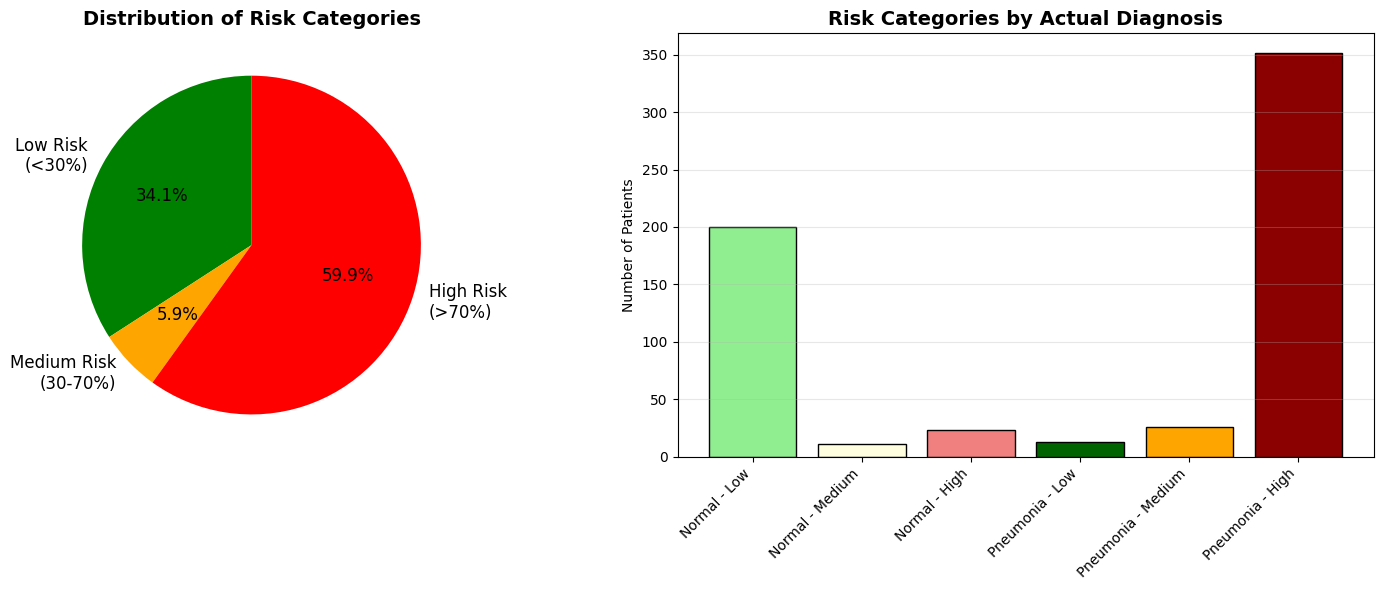

✓ Saved: risk_score_categories.png


In [ ]:
# Visualize risk score categories
print("\nGenerating risk score category visualization...")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of risk categories
risk_categories = ['Low Risk\n(<30%)', 'Medium Risk\n(30-70%)', 'High Risk\n(>70%)']
risk_counts = [low_risk, medium_risk, high_risk]
colors = ['green', 'orange', 'red']

axes[0].pie(risk_counts, labels=risk_categories, autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12})
axes[0].set_title('Distribution of Risk Categories', fontsize=14, weight='bold')

# Bar chart by actual diagnosis
risk_by_diagnosis = {
    'Normal - Low': np.sum((y_test == 0) & (risk_scores < 0.3)),
    'Normal - Medium': np.sum((y_test == 0) & (risk_scores >= 0.3) & (risk_scores < 0.7)),
    'Normal - High': np.sum((y_test == 0) & (risk_scores >= 0.7)),
    'Pneumonia - Low': np.sum((y_test == 1) & (risk_scores < 0.3)),
    'Pneumonia - Medium': np.sum((y_test == 1) & (risk_scores >= 0.3) & (risk_scores < 0.7)),
    'Pneumonia - High': np.sum((y_test == 1) & (risk_scores >= 0.7)),
}

categories = list(risk_by_diagnosis.keys())
values = list(risk_by_diagnosis.values())
bar_colors = ['lightgreen', 'lightyellow', 'lightcoral', 'darkgreen', 'orange', 'darkred']

axes[1].bar(range(len(categories)), values, color=bar_colors, edgecolor='black')
axes[1].set_xticks(range(len(categories)))
axes[1].set_xticklabels(categories, rotation=45, ha='right')
axes[1].set_ylabel('Number of Patients')
axes[1].set_title('Risk Categories by Actual Diagnosis', fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('risk_score_categories.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: risk_score_categories.png")


SAMPLE PATIENT PREDICTIONS WITH RISK SCORES


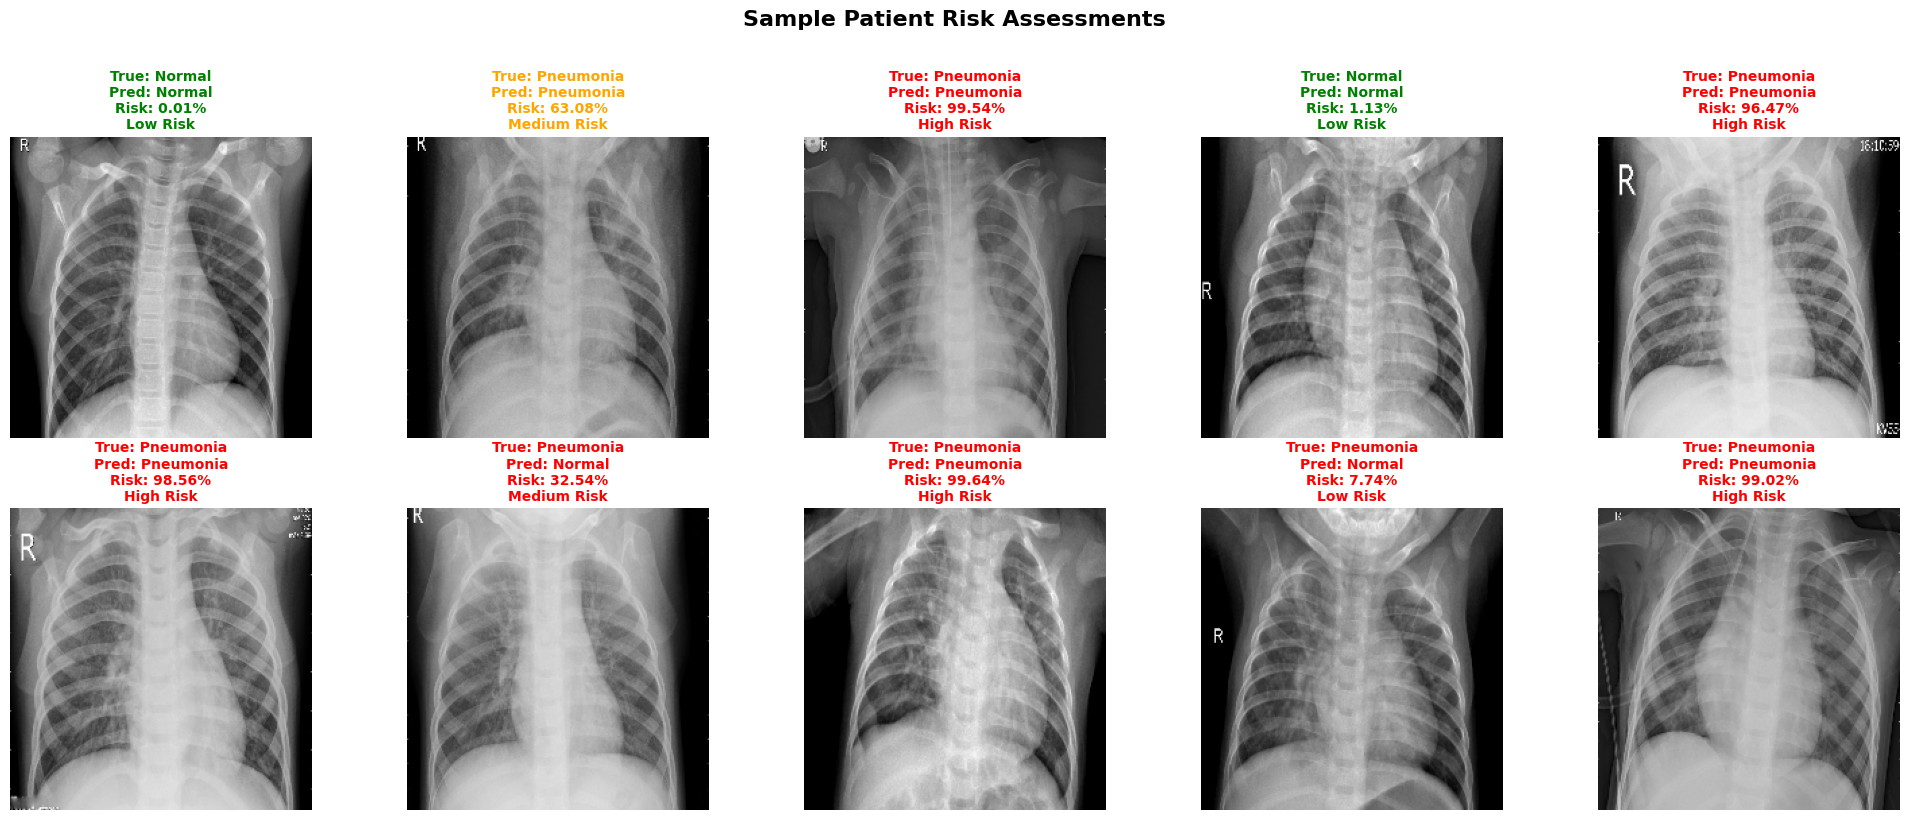

✓ Saved: sample_predictions.png


In [ ]:
print("\n" + "="*70)
print("SAMPLE PATIENT PREDICTIONS WITH RISK SCORES")
print("="*70)

# Show predictions for random samples
n_samples = 10
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for idx, sample_idx in enumerate(sample_indices):
    img = X_test[sample_idx]
    true_label = 'Pneumonia' if y_test[sample_idx] == 1 else 'Normal'
    pred_prob = risk_scores[sample_idx]
    pred_label = 'Pneumonia' if pred_prob > 0.5 else 'Normal'
    risk_level, color = interpret_risk(pred_prob)

    axes[idx].imshow(img.squeeze(), cmap='gray')
    title_color = color if pred_label == true_label else 'red'
    axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}\nRisk: {pred_prob:.2%}\n{risk_level}',
                        fontsize=10, color=title_color, weight='bold')
    axes[idx].axis('off')

    # Add border color
    for spine in axes[idx].spines.values():
        spine.set_edgecolor(title_color)
        spine.set_linewidth(3)

plt.suptitle('Sample Patient Risk Assessments', fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: sample_predictions.png")

In [ ]:
# Print detailed predictions with risk interpretation
print("\nDetailed Patient Risk Assessments:")
print("="*90)
print(f"{'Patient':<10} {'True':<12} {'Predicted':<12} {'Risk Score':<15} {'Risk Level':<15} {'Status'}")
print("="*90)

for idx, sample_idx in enumerate(sample_indices):
    true_label = 'Pneumonia' if y_test[sample_idx] == 1 else 'Normal'
    pred_prob = risk_scores[sample_idx]
    pred_label = 'Pneumonia' if pred_prob > 0.5 else 'Normal'
    risk_level, _ = interpret_risk(pred_prob)
    status = '✓ Correct' if pred_label == true_label else '✗ Incorrect'

    print(f"Patient {idx + 1:<2}  {true_label:<12} {pred_label:<12} {pred_prob:.4f} ({pred_prob*100:5.1f}%)  {risk_level:<15} {status}")

print("="*90)


Detailed Patient Risk Assessments:
Patient    True         Predicted    Risk Score      Risk Level      Status
Patient 1   Normal       Normal       0.0001 (  0.0%)  Low Risk        ✓ Correct
Patient 2   Pneumonia    Pneumonia    0.6308 ( 63.1%)  Medium Risk     ✓ Correct
Patient 3   Pneumonia    Pneumonia    0.9954 ( 99.5%)  High Risk       ✓ Correct
Patient 4   Normal       Normal       0.0113 (  1.1%)  Low Risk        ✓ Correct
Patient 5   Pneumonia    Pneumonia    0.9647 ( 96.5%)  High Risk       ✓ Correct
Patient 6   Pneumonia    Pneumonia    0.9856 ( 98.6%)  High Risk       ✓ Correct
Patient 7   Pneumonia    Normal       0.3254 ( 32.5%)  Medium Risk     ✗ Incorrect
Patient 8   Pneumonia    Pneumonia    0.9964 ( 99.6%)  High Risk       ✓ Correct
Patient 9   Pneumonia    Normal       0.0774 (  7.7%)  Low Risk        ✗ Incorrect
Patient 10  Pneumonia    Pneumonia    0.9902 ( 99.0%)  High Risk       ✓ Correct


In [ ]:
print("\nProcessing all test set patients...")

# Generate predictions for all test patients
y_pred_prob_all = model.predict(X_test, verbose=0)
y_pred_all = (y_pred_prob_all > 0.5).astype(int).flatten()
risk_scores_all = y_pred_prob_all.flatten()

# Function to interpret risk score
def interpret_risk(risk_score):
    """Interpret risk score and return risk level"""
    if risk_score < 0.3:
        return "Low Risk"
    elif risk_score < 0.7:
        return "Medium Risk"
    else:
        return "High Risk"

# Function to determine confidence level
def get_confidence_level(risk_score):
    """Calculate confidence level based on distance from decision boundary (0.5)"""
    confidence = abs(risk_score - 0.5) * 2  # Scale to 0-1
    if confidence >= 0.8:
        return "Very High"
    elif confidence >= 0.6:
        return "High"
    elif confidence >= 0.4:
        return "Moderate"
    else:
        return "Low"

# Create comprehensive results dataframe
results_data = []

for idx in range(len(X_test)):
    # Get predictions and scores
    true_label_numeric = int(y_test[idx])
    true_label = 'Pneumonia' if true_label_numeric == 1 else 'Normal'

    pred_prob = risk_scores_all[idx]
    pred_label_numeric = int(y_pred_all[idx])
    pred_label = 'Pneumonia' if pred_label_numeric == 1 else 'Normal'

    risk_level = interpret_risk(pred_prob)
    confidence = get_confidence_level(pred_prob)

    # Determine if prediction is correct
    is_correct = (pred_label == true_label)
    status = 'Correct' if is_correct else 'Incorrect'

    # Determine prediction type (TP, TN, FP, FN)
    if true_label_numeric == 1 and pred_label_numeric == 1:
        prediction_type = 'True Positive (TP)'
    elif true_label_numeric == 0 and pred_label_numeric == 0:
        prediction_type = 'True Negative (TN)'
    elif true_label_numeric == 0 and pred_label_numeric == 1:
        prediction_type = 'False Positive (FP)'
    else:  # true_label_numeric == 1 and pred_label_numeric == 0
        prediction_type = 'False Negative (FN)'

    # Calculate additional metrics
    normal_probability = 1 - pred_prob
    pneumonia_probability = pred_prob

    # Create patient record
    patient_record = {
        'Patient_ID': f'Patient_{idx+1:04d}',
        'Index': idx,
        'True_Label': true_label,
        'True_Label_Numeric': true_label_numeric,
        'Predicted_Label': pred_label,
        'Predicted_Label_Numeric': pred_label_numeric,
        'Pneumonia_Probability': pneumonia_probability,
        'Normal_Probability': normal_probability,
        'Risk_Score_Percentage': pred_prob * 100,
        'Risk_Level': risk_level,
        'Confidence_Level': confidence,
        'Prediction_Status': status,
        'Prediction_Type': prediction_type,
        'Is_Correct': is_correct
    }

    results_data.append(patient_record)

# Create DataFrame
results_df = pd.DataFrame(results_data)

print(f"✓ Processed {len(results_df)} patient records")


Processing all test set patients...
✓ Processed 624 patient records


In [ ]:
print("\nGenerating summary statistics...")

# Overall statistics
total_patients = len(results_df)
correct_predictions = results_df['Is_Correct'].sum()
accuracy = (correct_predictions / total_patients) * 100

# Confusion matrix components
true_positives = len(results_df[results_df['Prediction_Type'] == 'True Positive (TP)'])
true_negatives = len(results_df[results_df['Prediction_Type'] == 'True Negative (TN)'])
false_positives = len(results_df[results_df['Prediction_Type'] == 'False Positive (FP)'])
false_negatives = len(results_df[results_df['Prediction_Type'] == 'False Negative (FN)'])

# Calculate metrics
sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

# Risk level distribution
risk_distribution = results_df['Risk_Level'].value_counts()

# Summary dictionary
summary_stats = {
    'Metric': [
        'Total Patients',
        'Correct Predictions',
        'Incorrect Predictions',
        'Overall Accuracy (%)',
        '',
        'True Positives (TP)',
        'True Negatives (TN)',
        'False Positives (FP)',
        'False Negatives (FN)',
        '',
        'Sensitivity/Recall (%)',
        'Specificity (%)',
        'Precision (%)',
        'F1-Score (%)',
        '',
        'Low Risk Patients',
        'Medium Risk Patients',
        'High Risk Patients'
    ],
    'Value': [
        total_patients,
        correct_predictions,
        total_patients - correct_predictions,
        f'{accuracy:.2f}',
        '',
        true_positives,
        true_negatives,
        false_positives,
        false_negatives,
        '',
        f'{sensitivity * 100:.2f}',
        f'{specificity * 100:.2f}',
        f'{precision * 100:.2f}',
        f'{f1_score * 100:.2f}',
        '',
        risk_distribution.get('Low Risk', 0),
        risk_distribution.get('Medium Risk', 0),
        risk_distribution.get('High Risk', 0)
    ]
}

summary_df = pd.DataFrame(summary_stats)

print("✓ Summary statistics generated")


Generating summary statistics...
✓ Summary statistics generated


In [ ]:
print("\nSaving results to CSV files...")

# Create output directory if it doesn't exist
output_dir = 'pneumonia_detection_patient_details'
os.makedirs(output_dir, exist_ok=True)

# Generate timestamp for filenames
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save complete patient results
patient_results_filename = f'{output_dir}/all_patient_results_{timestamp}.csv'
results_df.to_csv(patient_results_filename, index=False)
print(f"✓ Saved: {patient_results_filename}")
print(f"  - {len(results_df)} patient records")

# Save summary statistics
summary_filename = f'{output_dir}/model_summary_statistics_{timestamp}.csv'
summary_df.to_csv(summary_filename, index=False)
print(f"✓ Saved: {summary_filename}")

# Save incorrect predictions for analysis
incorrect_predictions = results_df[results_df['Is_Correct'] == False]
incorrect_filename = f'{output_dir}/incorrect_predictions_{timestamp}.csv'
incorrect_predictions.to_csv(incorrect_filename, index=False)
print(f"✓ Saved: {incorrect_filename}")
print(f"  - {len(incorrect_predictions)} incorrect predictions")

# Save high-risk patients
high_risk_patients = results_df[results_df['Risk_Level'] == 'High Risk']
high_risk_filename = f'{output_dir}/high_risk_patients_{timestamp}.csv'
high_risk_patients.to_csv(high_risk_filename, index=False)
print(f"✓ Saved: {high_risk_filename}")
print(f"  - {len(high_risk_patients)} high-risk patients")

# Save false negatives (most critical - missed pneumonia cases)
false_negatives_df = results_df[results_df['Prediction_Type'] == 'False Negative (FN)']
false_negatives_filename = f'{output_dir}/false_negatives_CRITICAL_{timestamp}.csv'
false_negatives_df.to_csv(false_negatives_filename, index=False)
print(f"✓ Saved: {false_negatives_filename}")
print(f"  - {len(false_negatives_df)} false negative cases (CRITICAL)")






Saving results to CSV files...
✓ Saved: pneumonia_detection_patient_details/all_patient_results_20251202_030932.csv
  - 624 patient records
✓ Saved: pneumonia_detection_patient_details/model_summary_statistics_20251202_030932.csv
✓ Saved: pneumonia_detection_patient_details/incorrect_predictions_20251202_030932.csv
  - 53 incorrect predictions
✓ Saved: pneumonia_detection_patient_details/high_risk_patients_20251202_030932.csv
  - 374 high-risk patients
✓ Saved: pneumonia_detection_patient_details/false_negatives_CRITICAL_20251202_030932.csv
  - 27 false negative cases (CRITICAL)


In [ ]:
print("\nSaving trained model...")

# Save model directory
model_dir = 'pneumonia_trained_models'
os.makedirs(model_dir, exist_ok=True)

# Save as .h5 format (contains everything you need)
h5_model_path = f'{model_dir}/pneumonia_detection_model_{timestamp}.h5'
model.save(h5_model_path)
print(f"✓ Saved model: {h5_model_path}")


Saving trained model...
✓ Saved model: pneumonia_trained_models/pneumonia_detection_model_20251202_030932.h5


In [ ]:
print("\nSaving training history...")

# Convert history to DataFrame
history_df = pd.DataFrame(history.history)
history_df['epoch'] = range(1, len(history_df) + 1)

# Reorder columns
cols = ['epoch'] + [col for col in history_df.columns if col != 'epoch']
history_df = history_df[cols]

history_filename = f'{output_dir}/training_history_{timestamp}.csv'
history_df.to_csv(history_filename, index=False)
print(f"✓ Saved: {history_filename}")


Saving training history...
✓ Saved: pneumonia_detection_patient_details/training_history_20251202_030932.csv


In [ ]:
print("\nCreating model metadata...")

metadata = {
    'Parameter': [
        'Model Name',
        'Training Date',
        'TensorFlow Version',
        'Image Height',
        'Image Width',
        'Batch Size',
        'Epochs Trained',
        'Total Training Samples',
        'Total Validation Samples',
        'Total Test Samples',
        '',
        'Test Accuracy (%)',
        'Test Precision (%)',
        'Test Recall (%)',
        'Test F1-Score (%)',
        'Test AUC',
        '',
        'Model Architecture',
        'Total Parameters',
        'Trainable Parameters',
        'Optimizer',
        'Loss Function',
        '',
        'Data Augmentation',
        'Early Stopping Patience',
        'Learning Rate Reduction',
    ],
    'Value': [
        'Pneumonia Detection DCNN',
        timestamp,
        tf.__version__,
        IMG_HEIGHT,
        IMG_WIDTH,
        BATCH_SIZE,
        len(history.history['loss']),
        len(X_train),
        len(X_val),
        len(X_test),
        '',
        f'{accuracy:.2f}',
        f'{precision * 100:.2f}',
        f'{sensitivity * 100:.2f}',
        f'{f1_score * 100:.2f}',
        f'{test_auc:.4f}',
        '',
        'Deep CNN with 4 Conv Blocks',
        model.count_params(),
        sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]),
        'Adam (lr=0.001)',
        'Binary Crossentropy',
        '',
        'Rotation, Shift, Zoom, Flip',
        '10 epochs',
        'Factor=0.5, Patience=5',
    ]
}

metadata_df = pd.DataFrame(metadata)
metadata_filename = f'{model_dir}/model_metadata_{timestamp}.csv'
metadata_df.to_csv(metadata_filename, index=False)
print(f"✓ Saved: {metadata_filename}")



Creating model metadata...
✓ Saved: pneumonia_trained_models/model_metadata_20251202_030932.csv


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Copy folders to Google Drive
shutil.copytree('/content/pneumonia_detection_patient_details',
                '/content/drive/MyDrive/pneumonia_detection_patient_details')
shutil.copytree('/content/pneumonia_trained_models',
                '/content/drive/MyDrive/pneumonia_trained_models')

print("✓ Folders copied to Google Drive!")
print("Access them at: Google Drive > My Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Folders copied to Google Drive!
Access them at: Google Drive > My Drive
